In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
import scanpy as sc



# 读取数据
# data_name = 'zebrafish_dynamo_part'
# data_name = 'DG_bin_ppt'
# data_name = 'EG_ab_dyn'
# data_name = 'EG_bin_ppt'
data_name = 'A549_emt_bin_ppt'
# data_name = 'celltran_data'
GE = False
adata = sc.read('data/'+data_name+'.h5ad')

# 参数设置
if data_name == 'zebrafish_dynamo_part':
    k = 6 # 可以按照真实annotation做指导
elif data_name == 'celltran_data':
    k = 3
elif data_name == 'A549_emt_bin_ppt' or data_name == 'EG_bin_ppt':
    k = 4
else:
    k = 6
transfer_parameter = 0.2
startCluster = 1
isNormalized = True
Improve_efficiency = False


adata

AnnData object with n_obs × n_vars = 2961 × 437
    obs: 'Clusters', '_X', '_Y', 'batch', 'sample', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts', 'velocity_self_transition', 'root_cells', 'end_points', 'velocity_pseudotime', 'palantir_pseudotime', 'palantir_entropy'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'velocity_gamma', 'velocity_qreg_ratio', 'velocity_r2', 'velocity_genes'
    uns: 'DM_EigenValues', 'neighbors', 'palantir_waypoints', 'pca', 'sample_colors', 'umap', 'velocity_graph', 'velocity_graph_neg', 'velocity_params'
    obsm: 'DM_EigenVectors', 'DM_EigenVectors_multiscaled', 'X_pca', 'X_umap', 'palantir_fate_probabilities', 'velocity_pca'
    varm: 'PCs'
    layers: 'MAGIC_imputed_data', 'Ms', 'Mu', 'ambiguous', 'matrix', 'spliced', 'unspliced', 'variance_velocity', 'velocity'
    obsp: 'DM_Kernel', 'DM_Similarity', 'connectivities', 'distances'

In [18]:
if GE:
    result_path = 'scTite_results/GE_'+data_name+'/'
else:
    result_path = 'scTite_results/'+data_name+'/'
import os

folder = os.path.exists(result_path)
if not folder:                   #判断是否存在文件夹如果不存在则创建为文件夹
    os.makedirs(result_path)            #makedirs 创建文件时如果路径不存在会创建这个路径

In [19]:
if data_name == 'DG_bin_ppt' or data_name == 'A549_emt_bin_ppt':
    pltt = 'PCA'
    X_pca = adata.obsm['X_pca']
    X_pca[:,0] = -X_pca[:,0]
    X_plt = X_pca[:,0]
    Y_plt = X_pca[:,1]
    X_min = np.min(X_plt)
    X_max = np.max(X_plt)
    Y_min = np.min(Y_plt)
    Y_max = np.max(Y_plt)
    X_len = (X_max-X_min)/5
    Y_len = (Y_max-Y_min)/5
    wid = min(X_len,Y_len)/30
    X_ori = X_min
    Y_ori = Y_min

elif data_name == 'EG_bin_ppt':
    pltt = 'PCA'
    X_pca = adata.obsm['X_pca']
    X_pca[:,0] = X_pca[:,0]
    X_plt = X_pca[:,0]
    Y_plt = X_pca[:,1]
    X_min = np.min(X_plt)
    X_max = np.max(X_plt)
    Y_min = np.min(Y_plt)
    Y_max = np.max(Y_plt)
    X_len = (X_max-X_min)/5
    Y_len = (Y_max-Y_min)/5
    wid = min(X_len,Y_len)/30
    X_ori = X_min
    Y_ori = Y_min

else:
    pltt = 'UMAP'
    X_umap = adata.obsm['X_umap']
    X_plt = X_umap[:,0]
    Y_plt = X_umap[:,1]
    X_min = np.min(X_plt)
    X_max = np.max(X_plt)
    Y_min = np.min(Y_plt)
    Y_max = np.max(Y_plt)
    X_len = (X_max-X_min)/5
    Y_len = (Y_max-Y_min)/5
    wid = min(X_len,Y_len)/30
    X_ori = X_min
    Y_ori = Y_min   

In [20]:
# 软聚类
seed1 = 123
np.random.seed(seed1)
if GE:
    import torch
    if data_name == 'zebrafish_dynamo_part':
        encoder = torch.load('zebrafish_encoder.pt', weights_only = False)
        Xs = adata.layers['Ms']
    elif data_name == 'EG_ab_dyn':
        encoder = torch.load('EG_encoder.pt', weights_only = False)
        Xs = adata.layers['spliced']
    elif data_name == 'EG_bin_ppt':
        encoder = torch.load('EG_single_encoder.pt', weights_only = False)
        Xs = adata.layers['spliced']
    elif data_name == 'DG_bin_ppt':
        encoder = torch.load('DG_encoder.pt', weights_only = False)
        Xs = adata.layers['Ms']
    elif data_name == 'A549_emt_bin_ppt':
        encoder = torch.load('A549_encoder.pt', weights_only = False)
        Xs = adata.layers['Ms']

    if data_name == 'zebrafish_dynamo_part' or data_name == 'A549_emt_bin_ppt':
        mu, sigma = encoder(torch.tensor(Xs))
    else:
        mu, sigma = encoder(torch.tensor(Xs.toarray()))
    mu_learned = mu.detach().numpy()
    sigma_learned = sigma.detach().numpy()
    X = np.hstack([mu_learned, sigma_learned])  
else:  
    X = adata.obsm['X_umap'] # 用PCA，UMAP，GE都试一下！
# X = np.hstack([mu_learned, sigma_learned])
# X = mu_learned

print("开始聚类...")
# 使用高斯混合模型进行聚类
gmm = GaussianMixture(n_components=k, random_state=seed1)
gmm.fit(X)

mclust_label = gmm.predict(X) + 1  # R中索引从1开始
mclust_center = gmm.means_[:,:2]
mclust_probs = gmm.predict_proba(X)  # 对应R中的z

# 检查聚类效果
flag_stop = 0
for i in range(1, k+1):
    number_cluster_i = np.sum(mclust_label == i)
    if number_cluster_i < 10:
        flag_stop = 1

if len(np.unique(mclust_label)) != k:
    flag_stop = 1

if flag_stop == 1:
    print("聚类效果可能较差，请选择合适的聚类数或重新运行实验！")
else:
    print("聚类步骤完成！")



开始聚类...
聚类步骤完成！


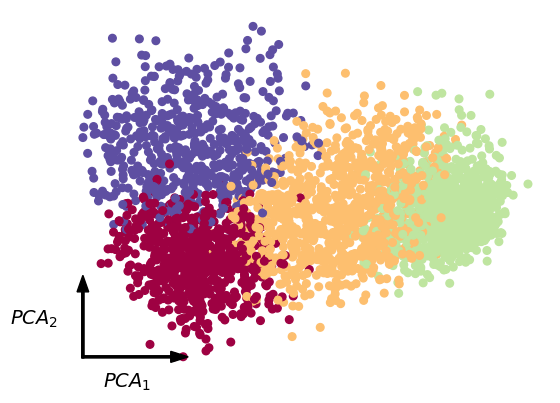

In [21]:
cmap = plt.colormaps['Spectral']
plt.scatter(X_plt,Y_plt,c=mclust_label,s=30,cmap=cmap)
plt.axis('off')

plt.arrow(X_ori-wid/2,Y_ori,X_len,0,width=wid,color='black',head_width=5*wid)
plt.arrow(X_ori,Y_ori-wid/2,0,Y_len,width=wid,color='black',head_width=5*wid)
plt.text(X_ori+X_len/2,Y_ori-wid*14,f'${pltt}_1$',fontsize=14,ha='center',weight='bold')
plt.text(X_ori-wid*21,Y_ori+Y_len/2,f'${pltt}_2$',fontsize=14,ha='center',weight='bold')

plt.savefig(result_path+'clustering.png')
plt.show()


In [22]:
# 计算转移熵
print("计算转移熵...")
probs = mclust_probs.T  # 转置以匹配R代码

# 计算熵
log_probs = np.zeros_like(probs)
for i in range(probs.shape[0]):
    for j in range(probs.shape[1]):
        if probs[i, j] != 0:
            log_probs[i, j] = probs[i, j] * np.log2(probs[i, j])

cluster_entropy = -np.sum(log_probs, axis=0)

# 创建熵和索引的组合
entropy_with_index = np.column_stack([cluster_entropy, np.arange(len(cluster_entropy))])

# 按熵值降序排列
temp_1 = entropy_with_index[np.argsort(-entropy_with_index[:, 0])]

# 选择前transfer_parameter%的细胞作为转移细胞
threshold = round(transfer_parameter * X.shape[0])
transfer_cell = temp_1[:threshold, 1].astype(int)

# 转移细胞坐标
transfer_cell_coordinate = np.column_stack([
    X[transfer_cell, :],
    transfer_cell,
    mclust_label[transfer_cell]
])

print(f"识别出 {len(transfer_cell)} 个转移细胞")

计算转移熵...
识别出 592 个转移细胞


In [23]:
def plot_transfer_cell(savepath = None):
    """绘制转移细胞图"""

    
    # 绘制所有细胞点
    colors = plt.cm.Set1(np.linspace(0, 1, k))
    for i in range(1, k+1):
        mask = mclust_label == i
        plt.scatter(X_plt[mask], Y_plt[mask], 
                   c=[colors[i-1]], s=20, alpha=0.6, label=f'Cluster {i}')
    
    # # 绘制聚类中心
    # plt.scatter(mclust_center[:, 0], mclust_center[:, 1], 
    #            c='black', s=100, marker='s', alpha=0.8, label='Centers')
    
    # # 添加聚类中心标签
    # for i, center in enumerate(mclust_center):
    #     plt.annotate(str(i+1), (center[0], center[1]), 
    #                 xytext=(5, 5), textcoords='offset points',
    #                 fontsize=12, color='blue', fontweight='bold')
    
    # 绘制转移细胞
    plt.scatter(X_plt[transfer_cell], Y_plt[transfer_cell], 
               c="#0A0401", s=30, alpha=0.8, label='Transfer cells')
    
    plt.arrow(X_ori-wid/2,Y_ori,X_len,0,width=wid,color='black',head_width=5*wid)
    plt.arrow(X_ori,Y_ori-wid/2,0,Y_len,width=wid,color='black',head_width=5*wid)
    plt.text(X_ori+X_len/2,Y_ori-wid*14,f'${pltt}_1$',fontsize=14,ha='center',weight='bold')
    plt.text(X_ori-wid*21,Y_ori+Y_len/2,f'${pltt}_2$',fontsize=14,ha='center',weight='bold')
    
    plt.axis('off')
    plt.xlabel(f'{pltt} 1')
    plt.ylabel(f'{pltt} 2')
    plt.title('Cell Clustering with Transfer Cells')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    if savepath:
        plt.savefig(savepath)
    plt.show()

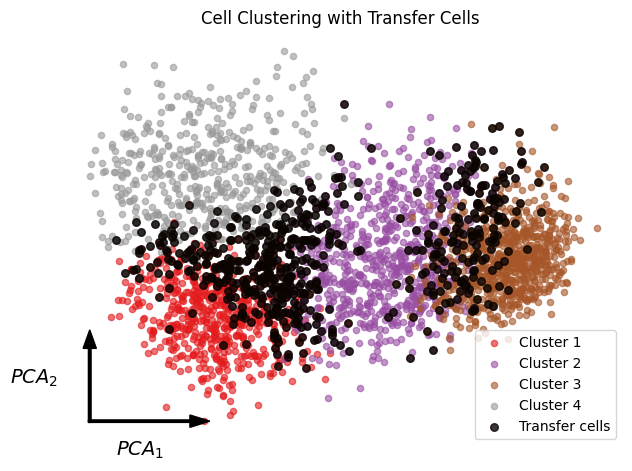


统计信息:
总细胞数: 2961
聚类数: 4
转移细胞数: 592
转移细胞比例: 19.99%


In [24]:
# 执行绘图
plot_transfer_cell(result_path+'transition cells')

# 打印一些统计信息
print(f"\n统计信息:")
print(f"总细胞数: {X.shape[0]}")
print(f"聚类数: {k}")
print(f"转移细胞数: {len(transfer_cell)}")
print(f"转移细胞比例: {len(transfer_cell)/X.shape[0]*100:.2f}%")